# Importing Libraries

In [ ]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os
import cv2

In [ ]:
# To avoid:- TensorFlow: Blas GEMM launch failed

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Importing Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_array = np.load('/content/drive/MyDrive/Minor Project (sem 6)/Datasets/Image colorization/features.npy')
print(data_array.shape)

(9294, 1, 256, 256, 3)


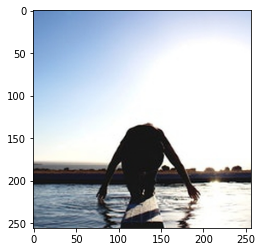

In [ ]:
plt.imshow(data_array[100].reshape(256,256,3))

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, _, _ = train_test_split(data_array, data_array, test_size = 0.2, random_state = 0)

In [ ]:
print(x_train.shape, x_test.shape)  

(7435, 1, 256, 256, 3) (1859, 1, 256, 256, 3)


In [ ]:
x_train = np.squeeze(x_train)
x_test = np.squeeze(x_test)

In [ ]:
print(x_train.shape, x_test.shape)

(7435, 256, 256, 3) (1859, 256, 256, 3)


In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [ ]:
x_train = np.reshape(x_train, (len(x_train), 256, 256, 3))
x_test = np.reshape(x_test, (len(x_test), 256, 256, 3))

In [ ]:
#type(x_train[0][0][0][0])

#### To generate synthetic noisy digits, we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [ ]:
noise_factor = 0.3

In [ ]:
noise_ = np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
noise_ = noise_.astype('float32')
x_train_noisy = x_train + noise_factor * noise_

In [ ]:
noise_ = np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
noise_ = noise_.astype('float32')
x_test_noisy = x_test + noise_factor * noise_

In [ ]:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

#### Original Images

In [ ]:
n = 10
plt.figure(figsize=(40, 8))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(256, 256, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#### Noisy Images

In [ ]:
n = 10
plt.figure(figsize=(40, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(256, 256, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Model(Remove Noise)

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

In [ ]:
input_img = keras.Input(shape=(256, 256, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)



x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 128, 128, 32)     

In [ ]:
from keras.callbacks import TensorBoard

ae = autoencoder.fit(x_train_noisy, 
                     x_train,
                     epochs=200,
                     batch_size=16,
                     shuffle=True,
                     validation_data=(x_test_noisy, x_test)
                     )                    

Epoch 1/200
465/465 [==============================] - 43s 92ms/step - loss: 0.5041 - accuracy: 0.6592 - val_loss: 0.4937 - val_accuracy: 0.7335
Epoch 2/200
465/465 [==============================] - 37s 81ms/step - loss: 0.4926 - accuracy: 0.7467 - val_loss: 0.4924 - val_accuracy: 0.7638
Epoch 3/200
465/465 [==============================] - 39s 84ms/step - loss: 0.4914 - accuracy: 0.7553 - val_loss: 0.4912 - val_accuracy: 0.7644
Epoch 4/200
465/465 [==============================] - 36s 77ms/step - loss: 0.4907 - accuracy: 0.7598 - val_loss: 0.4917 - val_accuracy: 0.7456
Epoch 5/200
465/465 [==============================] - 40s 87ms/step - loss: 0.4900 - accuracy: 0.7617 - val_loss: 0.4913 - val_accuracy: 0.7234
Epoch 6/200
465/465 [==============================] - 40s 87ms/step - loss: 0.4895 - accuracy: 0.7614 - val_loss: 0.4904 - val_accuracy: 0.7790
Epoch 7/200
465/465 [==============================] - 41s 88ms/step - loss: 0.4893 - accuracy: 0.7627 - val_loss: 0.4894 - val_ac

465/465 [==============================] - 44s 94ms/step - loss: 0.4861 - accuracy: 0.7856 - val_loss: 0.4865 - val_accuracy: 0.7772
Epoch 114/200
465/465 [==============================] - 43s 92ms/step - loss: 0.4861 - accuracy: 0.7851 - val_loss: 0.4867 - val_accuracy: 0.7925
Epoch 115/200
465/465 [==============================] - 42s 90ms/step - loss: 0.4861 - accuracy: 0.7850 - val_loss: 0.4866 - val_accuracy: 0.8027
Epoch 116/200
465/465 [==============================] - 42s 91ms/step - loss: 0.4860 - accuracy: 0.7847 - val_loss: 0.4866 - val_accuracy: 0.7826
Epoch 117/200
465/465 [==============================] - 43s 92ms/step - loss: 0.4861 - accuracy: 0.7851 - val_loss: 0.4867 - val_accuracy: 0.7981
Epoch 118/200
465/465 [==============================] - 43s 93ms/step - loss: 0.4860 - accuracy: 0.7842 - val_loss: 0.4865 - val_accuracy: 0.7929
Epoch 119/200
465/465 [==============================] - 47s 101ms/step - loss: 0.4860 - accuracy: 0.7859 - val_loss: 0.4869 - val_a

In [ ]:
autoencoder.save_weights('my_model_weights.h5')

In [ ]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 128, 128, 32)     

In [ ]:
_, accuracy = autoencoder.evaluate(x_train_noisy, x_train)
print(accuracy*100)

233/233 [==============================] - 11s 46ms/step - loss: 0.4860 - accuracy: 0.7893
78.92513871192932


In [ ]:
_, accuracy = autoencoder.evaluate(x_test_noisy, x_test)
print(accuracy*100)

59/59 [==============================] - 6s 95ms/step - loss: 0.4865 - accuracy: 0.7953
79.5284628868103


# Visualization after Denoising

In [ ]:
from pprint import pprint as pp
pp(ae.history)

{'accuracy': [0.6592118740081787,
              0.7466978430747986,
              0.7552528381347656,
              0.7598371505737305,
              0.7617300748825073,
              0.7614472508430481,
              0.7627273201942444,
              0.7644173502922058,
              0.7633686065673828,
              0.7661327719688416,
              0.7649862766265869,
              0.7682962417602539,
              0.7672252058982849,
              0.7679920196533203,
              0.769142746925354,
              0.7693656086921692,
              0.769387423992157,
              0.7697439193725586,
              0.7714060544967651,
              0.7700878381729126,
              0.7716910243034363,
              0.7722128629684448,
              0.7719553112983704,
              0.7732451558113098,
              0.7714707255363464,
              0.772819995880127,
              0.7724971771240234,
              0.7742992639541626,
              0.7735879421234131,
              0.7

<ipython-input-27-991f2822c540>:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy'])+1), len(model_history.history['accuracy'])/10)
<ipython-input-27-991f2822c540>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history['loss'])+1), len(model_history.history['loss'])/10)


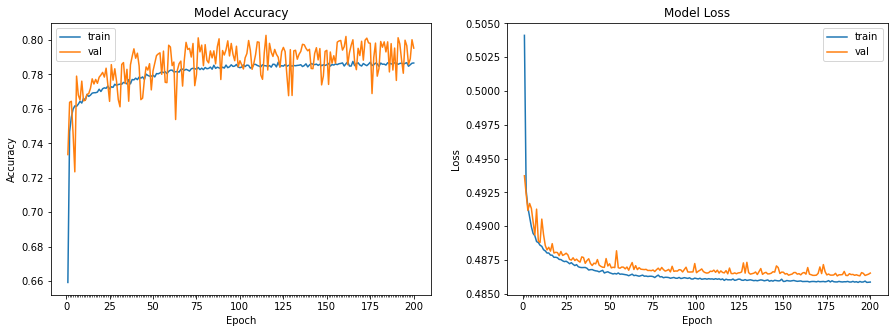

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize = (15,5))    
    
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy'])+1), model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_accuracy'])+1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy'])+1), len(model_history.history['accuracy'])/10)
    axs[0].legend(['train','val'], loc = 'best')
    
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss'])+1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss'])+1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss'])+1), len(model_history.history['loss'])/10)
    axs[1].legend(['train','val'], loc = 'best')
     
    plt.show()

plot_model_history(ae)   

#### `Noisy Images VS De-noised Images

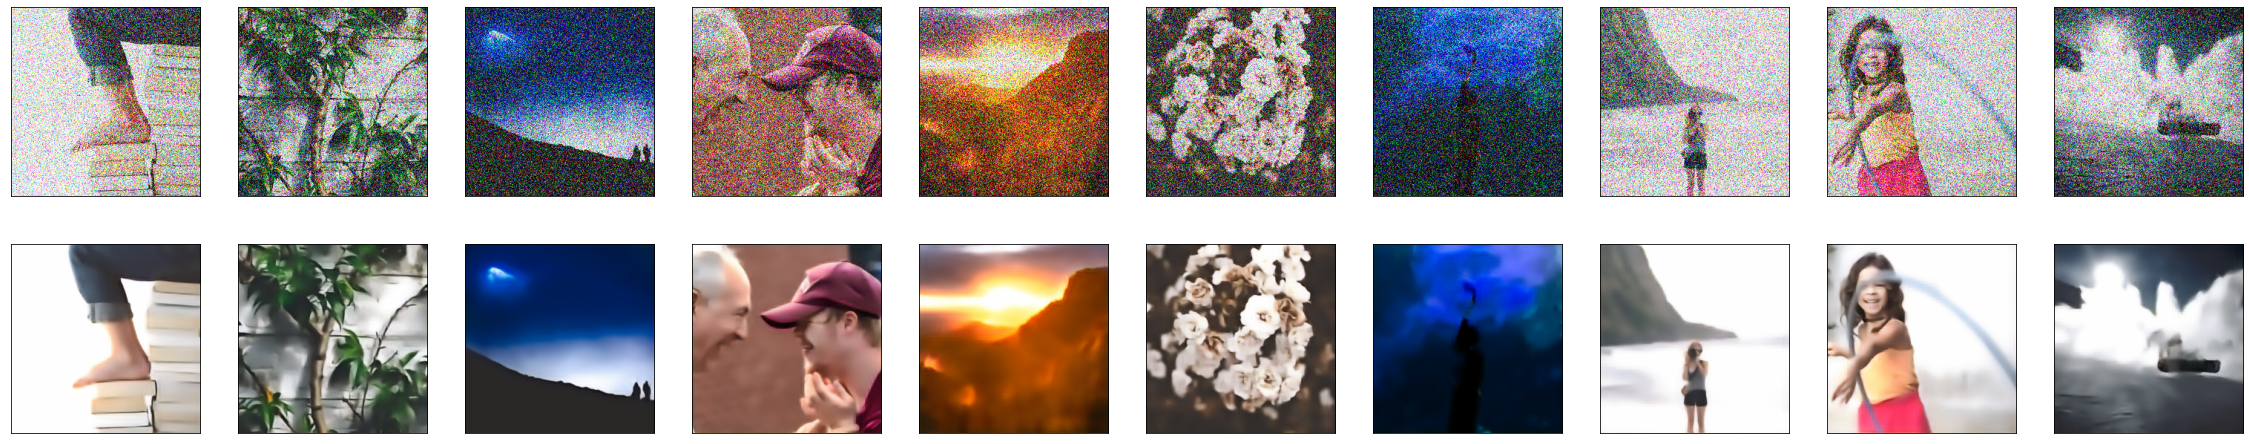

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(40, 8))
for i in range(1, n + 1):
    # Display noisy
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(256, 256, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    # Display denoised images
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(256, 256, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False) 
plt.show()